In [145]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


In [146]:
df = pd.read_csv('./data/1day.csv')
df.columns = ['open_time', 'open_price', 'high_price', 'low_price', 'close_price', 'volume', 'close_time']
df.head()
# timestamp to datetime
df = df.drop(['open_time'], axis=1)
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
df['close_day'] = df['close_time'].dt.day
df['close_month'] = df['close_time'].dt.month
df['close_year'] = df['close_time'].dt.year
# df = df[df['close_year'] == 2022]
df['target'] = np.where(df['close_price'].shift(-1) > df['close_price'], 1, 0)
df['open-close'] = df['open_price'] - df['close_price']
df['high-low'] = df['high_price'] - df['low_price']
df.tail()

,open_price,high_price,low_price,close_price,volume,close_time,close_day,close_month,close_year,target,open-close,high-low
2048,1715.21,1795.73,1701.13,1772.99,536511.3973,2023-03-28 23:59:59.999,28,3,2023,1,-57.78,94.60
2049,1773.00,1827.99,1772.48,1793.07,536865.5972,2023-03-29 23:59:59.999,29,3,2023,1,-20.07,55.51
2050,1793.06,1829.69,1763.00,1793.61,579690.0394,2023-03-30 23:59:59.999,30,3,2023,1,-0.55,66.69
2051,1793.60,1847.28,1777.91,1821.52,554525.4762,2023-03-31 23:59:59.999,31,3,2023,0,-27.92,69.37
2052,1821.52,1842.83,1807.81,1814.34,237296.4168,2023-04-01 23:59:59.999,1,4,2023,0,7.18,35.02


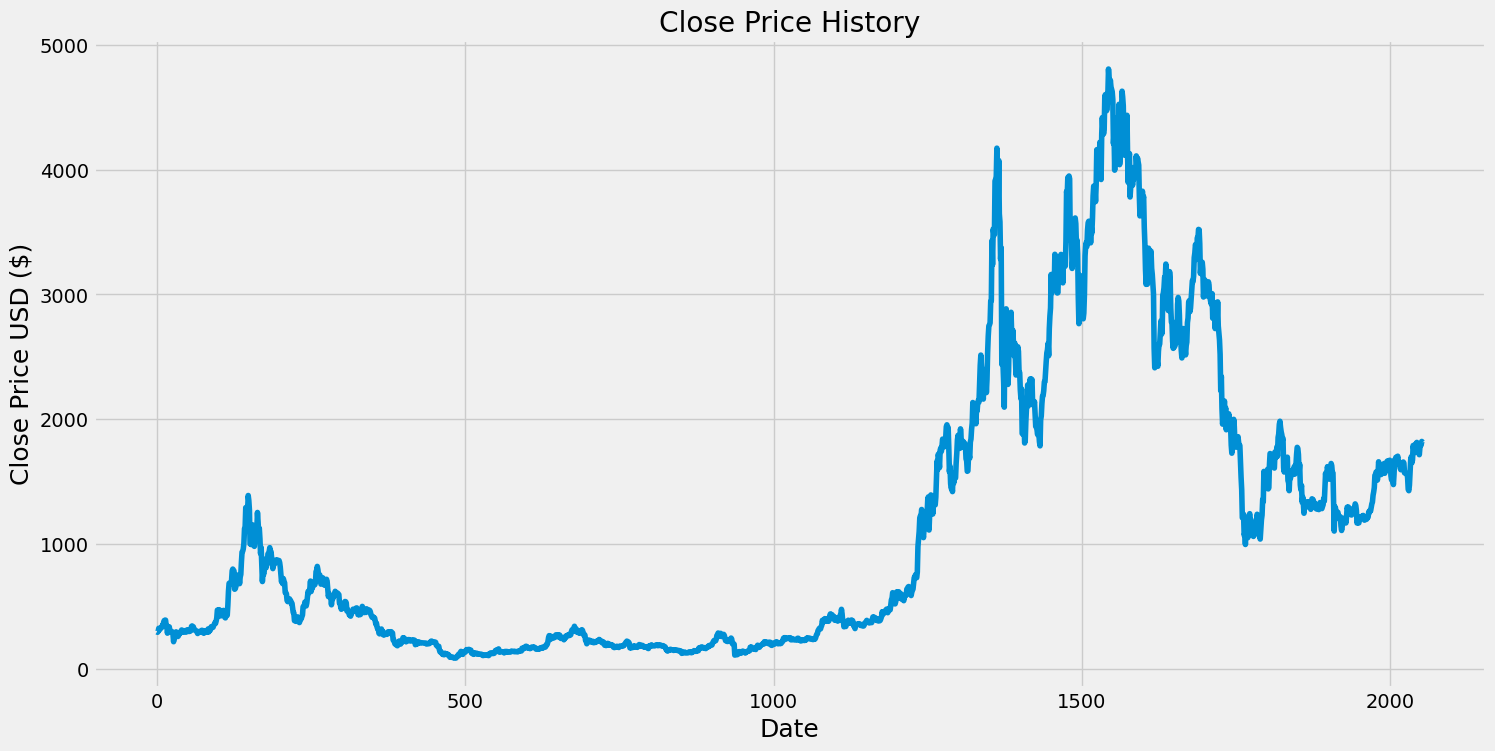

In [147]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['close_price'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()


In [148]:
target_y = df['target']
X_feat = df[['low_price', 'high_price']]

sc = MinMaxScaler(feature_range=(0,1))
X_ft = sc.fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns=X_feat.columns, data=X_ft, index=X_feat.index)

X_ft.head()

,low_price,high_price
0,0.043641,0.047416
1,0.042359,0.044930
2,0.043406,0.045062
3,0.045942,0.054677
4,0.013476,0.051309


In [149]:
print(X_ft.shape)
print(target_y.shape)

(2053, 2)
(2053,)


In [150]:
def lstm_split(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        v = i + n_steps
        X.append(data[i:v, :])
        y.append(data[v - 1, -1])

    return np.array(X), np.array(y)


In [151]:
X1, y1 = lstm_split(X_ft.values, 1)

train_split = 0.8
train_split = int(train_split * len(X1))

X_train, X_test = X1[:train_split], X1[train_split:]
y_train, y_test = y1[:train_split], y1[train_split:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1641, 1, 2) (411, 1, 2) (1641,) (411,)


In [152]:
lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm.add(LSTM(units=50, return_sequences=False))
lstm.add(Dense(units=25))
lstm.add(Dense(units=1))

lstm.compile(optimizer='adam', loss='mean_squared_error')

In [153]:
lstm.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=2, epochs=100, verbose=1)

Epoch 1/100
821/821 [==============================] - 3s 2ms/step - loss: 0.0059 - val_loss: 3.7684e-05
Epoch 2/100
821/821 [==============================] - 1s 1ms/step - loss: 8.6311e-05 - val_loss: 5.2804e-05
Epoch 3/100
821/821 [==============================] - 1s 1ms/step - loss: 9.3243e-05 - val_loss: 2.9591e-05
Epoch 4/100
821/821 [==============================] - 1s 1ms/step - loss: 1.1116e-04 - val_loss: 2.5964e-05
Epoch 5/100
821/821 [==============================] - 1s 1ms/step - loss: 6.7539e-05 - val_loss: 4.3100e-04
Epoch 6/100
821/821 [==============================] - 1s 1ms/step - loss: 1.0242e-04 - val_loss: 5.2117e-05
Epoch 7/100
821/821 [==============================] - 1s 1ms/step - loss: 1.0334e-04 - val_loss: 3.4769e-04
Epoch 8/100
821/821 [==============================] - 1s 1ms/step - loss: 5.9943e-05 - val_loss: 4.7604e-05
Epoch 9/100
821/821 [==============================] - 1s 1ms/step - loss: 7.9868e-05 - val_loss: 1.0103e-04
Epoch 10/100
821/821 [=

KeyboardInterrupt: 

In [154]:
y_pred = lstm.predict(X_test)

13/13 [==============================] - 0s 732us/step


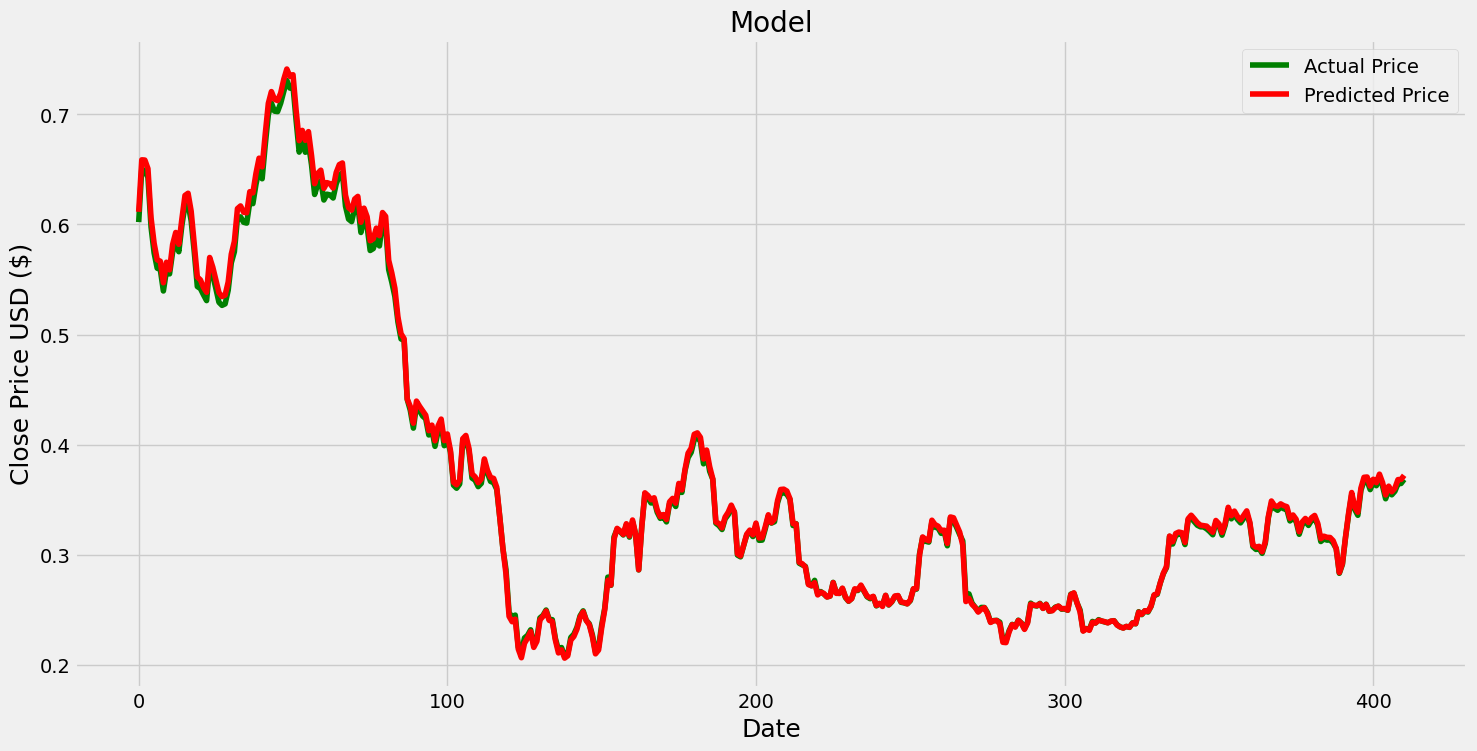

In [161]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
# plt.plot(X_train[:, -1], color='gray', label='Training Data')
plt.plot(y_test, color='green', label='Actual Price')
plt.plot(y_pred, color='red', label='Predicted Price')
plt.legend()    
plt.show()